### purpose

extract environmental importance data from nuisance runs to see how GF handled correlated envs

In [1]:
from pythonimports import *

import MVP_summary_functions as mvp

mvp.latest_commit()
session_info.show()

#########################################################
Today:	November 14, 2023 - 14:07:40 EST
python version: 3.8.5
conda env: mvp_env

Current commit of pythonimports:
commit 419895d157c97717f835390196c13cf973d25eba  
Merge: e20434f 1e09b6c  
Author: Brandon Lind <lind.brandon.m@gmail.com>

Current commit of MVP_offsets:
commit 947b68b2130080c7648ce4eb039c4dffacfd57d4  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Tue Nov 14 11:48:51 2023 -0500
#########################################################



In [2]:
# get seeds corresponding to 1-trait sims
params = mvp.read_params_file().iloc[:225]  # nuisance runs only run on one replicate

seeds = params[params.plevel == '1-trait'].seed.astype(str).tolist()

len(seeds), luni(seeds)

100%|███████████████| 2250/2250 [00:02<00:00, 841.77it/s]


(45, 45)

In [3]:
# get RDS files corresponding to 1-trait 1-nuisance runs of GF
rds_files = defaultdict(list)
rds_files['1-trait_1-nuisance'] = fs(
    f'{mvp.repdirs[0]}/gradient_forests/training/training_outfiles',
    exclude=list(set(params.seed.astype(str)) - set(seeds)),
    endswith='training.RDS'
)

assert len(rds_files['1-trait_1-nuisance']) / 3 == len(seeds)  # 3 marker sets per seed

### get other nuisance runs

In [4]:
outerdirs = {
    'ISO-PSsd' : '/home/b.lind/offsets/run_20220919_nuisance/ISO-PSsd_0-225',
    'ISO-TSsd-PSsd' : '/home/b.lind/offsets/run_20220919_nuisance/ISO-TSsd-PSsd_0-225'
}

for nuis_envs, outerdir in outerdirs.items():
    training_outdir = f'{outerdir}/gradient_forests/training/training_outfiles'
    
    files = fs(training_outdir, endswith='training.RDS')
    
    print(nuis_envs, len(files))
    
    found = []
    for f in files:
        seed = op.basename(f).split("_")[0]
        
        plevel = params.loc[seed, 'N_traits']
        
        base_nuis = 2 - plevel  # was sal_opt a nuis env?
        
        nuis_level = base_nuis + len(nuis_envs.split('-'))
        
        rds_files[f'{plevel}-trait_{nuis_level}-nuisance'].append(f)
        
for nuis_level, files in rds_files.items():
    print(nuis_level, len(files))

ISO-PSsd 675
ISO-TSsd-PSsd 675
1-trait_1-nuisance 135
1-trait_3-nuisance 135
2-trait_2-nuisance 540
1-trait_4-nuisance 135
2-trait_3-nuisance 540


In [5]:
# 2-trait have 540 files, which are 3 files (one per marker set) for each of 180 seeds
sum(params.N_traits == 2), 540 / sum(params.N_traits == 2)

(180, 3.0)

# retrieve importances

In [6]:
# create dirs for saving
output_parent = makedir('/home/b.lind/offsets/run_20220919_nuisance/importances_1-trait_ISO-PSsd_ISO-TSsd-PSsd')

output_dir = makedir(f'{output_parent}/importances')

output_shdir = makedir(f'{output_parent}/shfiles')

In [10]:
# create shfiles
imp_script = '/home/b.lind/code/MVP-offsets/01_src/MVP_04_env_importance_from_gradient_forests.R'

outfiles = []
shfiles = []
for nuis_level, files in rds_files.items():
    for rds_file in pbar(files, desc=nuis_level):
        seed, nuis_envs, *_, marker_set = op.basename(rds_file).split("_")[:-3]
        assert marker_set in ['all', 'adaptive', 'neutral']
        
        basename = f'{nuis_level}_{seed}_{marker_set}_importances'
        outfile = f'{output_dir}/{basename}.txt'
        
        outfiles.append(outfile)
        
        text = f'''#!/bin/bash
#SBATCH --job-name={basename}
#SBATCH --time=00:05:00
#SBATCH --mem=10000
#SBATCH --output={basename}_%j.out

source $HOME/.bashrc  # assumed that conda init is within .bashrc
conda deactivate
conda activate r35

Rscript {imp_script} {rds_file} {outfile}

'''
        
        shfile = f'{output_shdir}/{basename}.sh'
        with open(shfile, 'w') as o:
            o.write(text)
            
        shfiles.append(shfile)

        
for file_set in [outfiles, shfiles]:
    assert len(file_set) == luni(file_set)

2-trait_3-nuisance: 100%|███████████████| 540/540 [00:09<00:00, 55.26it/s]


In [8]:
pids = sbatch(shfiles)

sbatching: 100%|███████████████| 1485/1485 [05:22<00:00,  4.60it/s]


In [9]:
Squeue(p='short', states='PD').update(to_partition='long', num_jobs=0.5)

update:   3%|▍              | 10/315 [00:00<00:22, 13.68it/s]


KeyboardInterrupt: 

In [ ]:
Squeue(p='short', states='PD').update(to_partition='lotterhos', num_jobs=100)

In [ ]:
create_watcherfile(pids, output_shdir, watcher_name='importance_watcher')

In [ ]:
Squeue()

In [11]:
outs = fs(output_shdir, endswith='.out', exclude='watch')

len(outs), len(shfiles)

(1485, 1485)

In [12]:
lview, dview = get_client(cluster_id='1699987016-s5wv', profile='lotterhos')

seffs = Seffs.parallel(lview, outs=outs).most_recent()

36 36

Watching 1485 parallel Seffs jobs ...


retrieving seffs: 100%|███████████████| 1485/1485 [00:17<00:00, 83.86it/s]


In [16]:
seffs.states.counter()

Counter({'State: COMPLETED (exit code 0)': 1380,
         'State: FAILED (exit code 137)': 21,
         'State: FAILED (exit code 1)': 84})

In [17]:
# not sure why they failed, out files say "killed", but commands work manually, so resubmit!
pids = sbatch(seffs.failed().shfiles)

sbatching: 100%|███████████████| 105/105 [00:19<00:00,  5.48it/s]


In [25]:
Squeue(states='pd', partition='short').update(to_partition='lotterhos')

	no jobs in queue matching query
	None of the jobs in Squeue class passed criteria, or no jobs passing criteria were pending.


In [27]:
Squeue().watch()

🗒️  Queue Summary:

{'lotterhos': {'R': 1}}


sleeping:  40%|██████         | 2/5 [00:02<00:03,  1.04s/it]

KeyboardInterrupt after 2 seconds of sleep.


In [30]:
outs = fs(output_shdir, endswith='.out', exclude='watch')

seffs = Seffs.parallel(lview, outs=outs).most_recent()


Watching 1590 parallel Seffs jobs ...


retrieving seffs: 100%|███████████████| 1590/1590 [00:19<00:00, 80.71it/s]
/home/b.lind/pythonimports/myslurm.py:552: UserWarning: There are multiple shfiles associated with outfiles. len=1590 luni=1485
  warnings.warn(text)


In [31]:
seffs.states.counter()

Counter({'State: COMPLETED (exit code 0)': 1476,
         'State: FAILED (exit code 137)': 7,
         'State: FAILED (exit code 1)': 2})

In [32]:
read(seffs.failed().outs[0])

['Loading required package: extendedForest',
 'extendedForest 1.6.1',
 'Type rfNews() to see new features/changes/bug fixes.',
 '/var/spool/slurmd/job39547164/slurm_script: line 11: 17410 Killed                  Rscript /home/b.lind/code/MVP-offsets/01_src/MVP_04_env_importance_from_gradient_forests.R /home/b.lind/offsets/run_20220919_nuisance/ISO-PSsd_0-225/gradient_forests/training/training_outfiles/1231249_ISO-PSsd_GF_training_pooled_neutral_gradient_forest_training.RDS /home/b.lind/offsets/run_20220919_nuisance/importances_1-trait_ISO-PSsd_ISO-TSsd-PSsd/importances/1-trait_3-nuisance_1231249_neutral_importances.txt',
 '']

In [33]:
pids = sbatch(seffs.failed().shfiles)

sbatching: 100%|███████████████| 9/9 [00:01<00:00,  6.17it/s]


In [35]:
Squeue().watch()

🗒️  Queue Summary:

{'lotterhos': {'R': 1}}


sleeping:  60%|█████████      | 3/5 [00:03<00:02,  1.27s/it]

KeyboardInterrupt after 3 seconds of sleep.


In [39]:
outs = fs(output_shdir, endswith='.out', exclude='watch')

seffs = Seffs.parallel(lview, outs=outs).most_recent()

seffs.states.counter()


Watching 1599 parallel Seffs jobs ...


retrieving seffs: 100%|███████████████| 1599/1599 [00:19<00:00, 81.37it/s]
/home/b.lind/pythonimports/myslurm.py:552: UserWarning: There are multiple shfiles associated with outfiles. len=1599 luni=1485
  warnings.warn(text)


Counter({'State: COMPLETED (exit code 0)': 1485})

In [41]:
len(fs(output_dir, endswith='.txt'))

1485

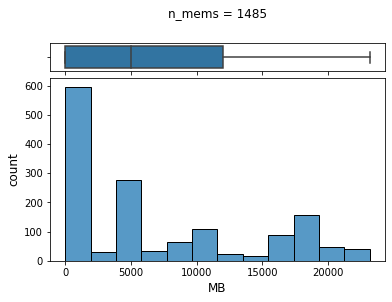

In [42]:
seffs.completed().plot_mems()

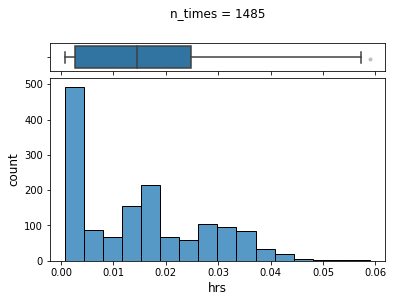

In [43]:
seffs.completed().plot_times()

In [104]:
output_parent

'/home/b.lind/offsets/run_20220919_nuisance/importances_1-trait_ISO-PSsd_ISO-TSsd-PSsd'

In [105]:
pkldump(seffs, f'{output_parent}/seffs.pkl')

# make figs

In [102]:
# For each marker set, did GF’s weighted importance rank the adaptive envs (n = n_adaptive) in the ... 
    # top n_adaptive envs? True = the adaptive envs were ranked at the top, False = at least one ...
    # nuisance env was ranked in the top n_adaptive envs. (order of rank is unimportant)
    
outputfiles = fs(output_dir, endswith='.txt')

pie_data = wrap_defaultdict(Counter, 2)
for f in pbar(outputfiles):
    num_traits, num_nuisance, seed, marker_set, *_ = op.basename(f).split("_")
    nuis_level = f'{num_traits}_{num_nuisance}'
    
    df = pd.read_table(f).sort_values(by='weighted_importance', ascending=False)
    
    if num_traits == '1-trait':
        correct = pd.Series(['temp_opt'])
        stopat = 1
    else:
        correct = pd.Series(['temp_opt', 'sal_opt'])
        stopat = 2
        
    # are the expected envs in the top ranked (order doesn't matter)
    num_correct = correct.isin(df.iloc[:stopat].index).sum()

    # are the adaptive envs the top ranked?
    pie_data[nuis_level][marker_set][num_correct == stopat] += 1
    
df

100%|███████████████| 1485/1485 [00:05<00:00, 292.26it/s]


,overall_importance,weighted_importance,accuracy_importance
temp_opt,0.004377,0.079331,0.004377
PSsd,0.002805,0.053131,0.002805
sal_opt,0.002007,0.037936,0.002007
TSsd,0.001888,0.036447,0.001888
ISO,0.001969,0.036247,0.001969


In [103]:
# show results to question
for nuis_level in pie_data:
    print(ColorText(f'\n{nuis_level}').bold())
    for marker_set in pie_data[nuis_level]:
        print(marker_set, pie_data[nuis_level][marker_set])


1-trait_1-nuisance
adaptive Counter({True: 45})
all Counter({True: 45})
neutral Counter({True: 45})

1-trait_3-nuisance
adaptive Counter({True: 45})
all Counter({True: 43, False: 2})
neutral Counter({True: 38, False: 7})

1-trait_4-nuisance
adaptive Counter({True: 43, False: 2})
all Counter({True: 36, False: 9})
neutral Counter({True: 35, False: 10})

2-trait_2-nuisance
adaptive Counter({True: 120, False: 60})
all Counter({False: 119, True: 61})
neutral Counter({False: 119, True: 61})

2-trait_3-nuisance
adaptive Counter({True: 140, False: 40})
all Counter({False: 119, True: 61})
neutral Counter({False: 119, True: 61})
